# Nuclei Detection using CNNs and U-net Architecture

+ I will be trying two to three architectures and finally report the LB scores 
+ I will put down the benifits and disadvantages of each approach

## Using Amzn s3 Buckets and Sagemaker


### Notes

- Using the sagemaker tutorials @ https://us-west-2.console.aws.amazon.com/sagemaker/home?region=us-west-2#/notebook-instances/Nucleidetection-Trial-1
- You transform the data by changing its format from numpy.array to RecordIO. The RecordIO format is more efficient for the algorithms provided by Amazon SageMaker. For information about the RecordIO format, see http://mxnet.incubator.apache.org/architecture/note_data_loading.html#data-format
+ Accesing s3 buckets using **boto3** package https://dluo.me/s3databoto3
+ SO information : https://stackoverflow.com/questions/35803027/retrieving-subfolders-names-in-s3-bucket-from-boto3

### Getting the Data and Intial Data visualizations

In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
%matplotlib inline

Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
# Set some parameters
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
#TRAIN_PATH = '../input/stage1_train/'
#TEST_PATH = '../input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [4]:
from sagemaker import get_execution_role

role=get_execution_role()
bucket='sagemaker-datascience-bowl'

In [5]:
%%time
import pickle, gzip, numpy, urllib.request, json

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 15 µs


In [6]:
%%time
import boto3
client=boto3.client('s3')

response=client.list_buckets()
buckets=[bucket['Name'] for bucket in response['Buckets']]
print("Bucket List: %s"% buckets)

data_key='stage1_train/'
data_location='s3://{}//{}'.format(bucket, data_key)

Bucket List: ['sagemaker-datascience-bowl']
CPU times: user 48 ms, sys: 4 ms, total: 52 ms
Wall time: 318 ms


In [7]:
folders=[]
paginator = client.get_paginator('list_objects')
for result in paginator.paginate(Bucket=bucket, Delimiter='/'):
    for prefix in result.get('CommonPrefixes'):
        folders.append(prefix.get('Prefix'))
print(folders)        

['stage1_sample_submission.csv/', 'stage1_test/', 'stage1_train/', 'stage1_train_labels.csv/']


In [8]:
paths = [ bucket+"/"+p for p in folders]
paths

['sagemaker-datascience-bowl/stage1_sample_submission.csv/',
 'sagemaker-datascience-bowl/stage1_test/',
 'sagemaker-datascience-bowl/stage1_train/',
 'sagemaker-datascience-bowl/stage1_train_labels.csv/']

In [9]:
resource = boto3.resource('s3')
my_bucket = resource.Bucket(bucket)
files_train=list(my_bucket.objects.filter(Prefix=folders[2]))
files_test=list(my_bucket.objects.filter(Prefix=folders[1]))

## Get the Train and the Test Ids here
+ Train Ids and Test Ids Extraction 
+ Checking some random Training imgages 
+ Checking some random Test images

In [10]:
print("-------------------------------------------------Train files in s3 bucket information----------------------")
print("\n\n")
# Check the paths for images and texts in the train folder randomly
for i in range(28):
    print(files_train[i].key)
print("---------------------------------------------------------------------------")
print(files_train[28].key)
print("\n\n")
print("--------------------------------------------------Test file in s3 bucket information------------------------")
# check the paths for images in the test folder, test folder does not have any masks
for i in range(10):
    print(files_test[i].key)
print("\n\n")    
print("Length of the the test folder:{}".format(len(files_test)))    

-------------------------------------------------Train files in s3 bucket information----------------------



stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png
stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/07a9bf1d7594af2763c86e93f05d22c4d5181353c6d3ab30a345b908ffe5aadc.png
stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/0e548d0af63ab451616f082eb56bde13eb71f73dfda92a03fbe88ad42ebb4881.png
stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/0ea1f9e30124e4aef1407af239ff42fd6f5753c09b4c5cac5d08023c328d7f05.png
stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/0f5a3252d05ecdf453bdd5e6ad5322c454d8ec2d13ef0f0bf45a6f6db45b5639.png
stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/2c47735510ef91a11fde42b317829cee5fc04d0

In [11]:
train_ids = [files_train[i].key.split('/')[1].strip() for i in range(len(files_train)) if 'images' in files_train[i].key.split('/')]
test_ids = [files_test[i].key.split('/')[1].strip() for i in range(len(files_test))]
print(len(train_ids), len(test_ids))
print(train_ids[0:10])
print("\n")
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks')
sys.stdout.flush()

from io import BytesIO
count=0
for n, id_ in tqdm(enumerate(files_train)):
    tag = files_train[n].key.split('/')[1]   #to tag masks or images , this is not required
    id_train = files_train[n].key.split('/') #splitted key
    if 'images' in id_train: 
        #print("shape of the train image {}".format(path_im_train[1]),imread(files_train[i].get()['Body']).shape)
        img=imread(files_train[n].get()['Body'])[:,:,:IMG_CHANNELS]
        img=resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[count]=img
        count+=1
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    elif 'masks' in id_train:
        mask_ = imread(files_train[n].get()['Body'])
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
        Y_train[count-1]=mask
print(count)        
#     print("------------------------------Test------------------------")
#     print("shape of the test image {}".format(path_im_test[1]),imread(files_test[i].get()['Body']).shape)
#     img_ts = imread(files_test[i].get()['Body'])[:,:,:IMG_CHANNELS]
#     img_ts = resize(img_ts, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     imshow(img_ts)
#     plt.show()
#     imread(files_test[i].get()['Body']).shape

670 65
['00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552', '003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1', '00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e', '0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed', '01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf', '0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21', '0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426', '02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339', '03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776', '03b9306f44e9b8951461623dcbd615550cdcf36ea93b203f2c8fa58ed1dffcbe']


Getting and resizing train images and masks


30131it [21:59, 22.84it/s]

670


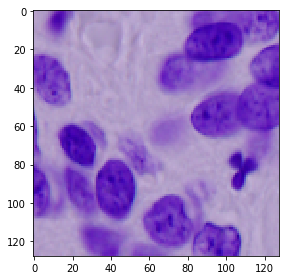

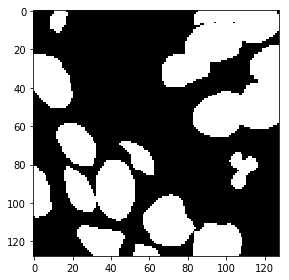

In [12]:
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [13]:
# Get and resize test images as well and take a look

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test=[]
print('Getting and resizing the test images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(files_test), total=len(files_test)):
    img = imread(files_test[n].get()['Body'])[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img=resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n]=img
print('Done the processing !!')    

Getting and resizing the test images ... 


100%|██████████| 65/65 [00:05<00:00, 12.27it/s]

Done the processing !!


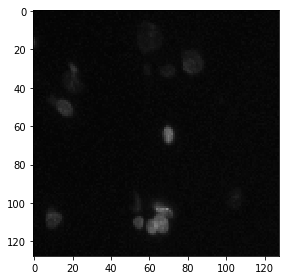

In [14]:
ix=random.randint(0, len(test_ids))
imshow(X_test[ix])
plt.show()

## Understanding the IOU metric to calculate the mean average Precision metric 
+ We use Keras for defining this metric , this metric is also defined in TF
+ Iou is Intersection over Union , as the name suggests, This metric support is not predefined and we need to define this on our own 
+ As I go through in implementing this function, I find that it is not easy to implement the tf.metrics.mean_iou(), All that is given in the tensorflow docs, is below, Basically this just tells us what IoU is, but does not tell in detail how to use it
+ **Calculate per-step mean Intersection-Over-Union (mIOU).**

    + Mean Intersection-Over-Union is a common evaluation metric for semantic image segmentation, which first computes the IOU for each semantic class and then computes the average over classes. IOU is defined as follows: IOU = true_positive / (true_positive + false_positive + false_negative). The predictions are accumulated in a confusion matrix, weighted by weights, and mIOU is then calculated from it.

    + For estimation of the metric over a stream of data, the function creates an update_op operation that updates these variables and returns the mean_iou.
    
+ **As per the competition , the definition of the function is as below**
    + This competition is evaluated on the mean average precision at different intersection over union (IoU) thresholds. The IoU of a proposed set of object pixels and a set of true object pixels is calculated as:
    > **IoU(A,B)=A∩B/A∪B.** 
    
    **The metric sweeps over a range of IoU thresholds, at each point calculating an average precision value. The threshold values range from 0.5 to 0.95 with a step size of 0.05: (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95). In other words, at a threshold of 0.5, a predicted object is considered a "hit" if its intersection over union with a ground truth object is greater than 0.5.**

    + At each threshold value t, a precision value is calculated based on the number of true positives (TP), false negatives (FN), and false positives (FP) resulting from comparing the predicted object to all ground truth objects:
    > **TP(t)/(TP(t)+FP(t)+FN(t))**
    

+ A true positive is counted when a single predicted object matches a ground truth object with an IoU above the threshold. A false positive indicates a predicted object had no associated ground truth object. A false negative indicates a ground truth object had no associated predicted object. The average precision of a single image is then calculated as the mean of the above precision values at each IoU threshold:Lastly, the score returned by the competition metric is the mean taken over the individual average precisions of each image in the test dataset.

+ There is some reading involved here , and there are some implementations that I have to go through, putting down my resources that have inspired me and helped me design this metric
    - https://www.kaggle.com/c/data-science-bowl-2018/discussion/47690
    - https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
    - http://ronny.rest/blog/post_2017_09_11_tf_metrics/

In [16]:
# define the IOU function using tf.metrics.mean_iou, this is a much simpler implementation and straight to use

def mean_iou(y_true, y_pred):
    prec=[]
    for th in np.arange(0.5, 1.0, 0.05):
        y_pred = tf.to_int32(y_pred>th)
        score, up_op= tf.metrics.mean_iou(y_true, y_pred, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_op]): #Control dependecies are important as this will make sure the assignment is done for update operation first
            score=tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0) #stacks along axis 0

### Simple CNN Architecture 
+ Using a simple CNN architecture to get a benchmark to whether this can predict based on the Iou

In [111]:
# Make Simple CNN model and Test it here
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Conv2D, UpSampling2D, Lambda
from keras import backend as K

simple_cnn = Sequential()
simple_cnn.add(BatchNormalization(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name="NormalizeInput"))
simple_cnn.add(Conv2D(8, kernel_size=(3,3), padding='same'))
simple_cnn.add(Conv2D(8, kernel_size=(3,3), padding='same'))

simple_cnn.add(Conv2D(16, kernel_size=(3,3), dilation_rate=2, padding='same'))
simple_cnn.add(Conv2D(16, kernel_size=(3,3), dilation_rate=2, padding='same'))
simple_cnn.add(Conv2D(32, kernel_size=(3,3), dilation_rate=2, padding='same'))


simple_cnn.add(Conv2D(16, kernel_size=(1,1), padding='same'))
simple_cnn.add(Conv2D(1, kernel_size=(1,1), padding='same', activation='sigmoid'))
simple_cnn.summary()

inputs=Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s=Lambda(lambda x:x/255) (inputs) #normalization
encoded_images = simple_cnn(s)
outputs = Dense(1, activation='sigmoid') (encoded_images)

cnnmodel = Model(inputs = [inputs], outputs=[outputs])
cnnmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 128, 128, 8)       224       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 128, 128, 8)       584       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 128, 128, 16)      1168      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 128, 128, 16)      528       
__________

In [113]:
# Lets do some training here
earlystopper = EarlyStopping(patience=4, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-mode-simplecnn-ep-50.h5', verbose=1, save_best_only=True)
results=cnnmodel.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=150, callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/150
603/603 [==============================] - 55s 91ms/step - loss: 0.7664 - mean_iou: 0.2868 - val_loss: 0.7090 - val_mean_iou: 0.3877
Epoch 2/150
603/603 [==============================] - 55s 91ms/step - loss: 0.7402 - mean_iou: 0.4168 - val_loss: 0.6916 - val_mean_iou: 0.4298
Epoch 3/150
603/603 [==============================] - 54s 90ms/step - loss: 0.7182 - mean_iou: 0.4407 - val_loss: 0.6745 - val_mean_iou: 0.4531
Epoch 4/150
603/603 [==============================] - 55s 92ms/step - loss: 0.7016 - mean_iou: 0.4590 - val_loss: 0.6592 - val_mean_iou: 0.4645
Epoch 5/150
603/603 [==============================] - 54s 90ms/step - loss: 0.6830 - mean_iou: 0.4686 - val_loss: 0.6435 - val_mean_iou: 0.4739
Epoch 6/150
603/603 [==============================] - 55s 90ms/step - loss: 0.6562 - mean_iou: 0.4804 - val_loss: 0.6129 - val_mean_iou: 0.4874
Epoch 7/150
603/603 [==============================] - 55s 92ms/step - loss: 0.6122 -

603/603 [==============================] - 54s 90ms/step - loss: 0.4401 - mean_iou: 0.6424 - val_loss: 0.4288 - val_mean_iou: 0.6448
Epoch 26/150
603/603 [==============================] - 54s 90ms/step - loss: 0.4319 - mean_iou: 0.6473 - val_loss: 0.4228 - val_mean_iou: 0.6497
Epoch 27/150
603/603 [==============================] - 55s 92ms/step - loss: 0.4297 - mean_iou: 0.6519 - val_loss: 0.4227 - val_mean_iou: 0.6539
Epoch 28/150
603/603 [==============================] - 55s 90ms/step - loss: 0.4318 - mean_iou: 0.6554 - val_loss: 0.4229 - val_mean_iou: 0.6567
Epoch 29/150
603/603 [==============================] - 55s 91ms/step - loss: 0.4222 - mean_iou: 0.6580 - val_loss: 0.4077 - val_mean_iou: 0.6596
Epoch 30/150
603/603 [==============================] - 55s 91ms/step - loss: 0.4158 - mean_iou: 0.6610 - val_loss: 0.3996 - val_mean_iou: 0.6625
Epoch 31/150
603/603 [==============================] - 55s 91ms/step - loss: 0.4034 - mean_iou: 0.6644 - val_loss: 0.3926 - val_mean_iou

Epoch 50/150
603/603 [==============================] - 55s 92ms/step - loss: 0.3173 - mean_iou: 0.7116 - val_loss: 0.3076 - val_mean_iou: 0.7125
Epoch 51/150
603/603 [==============================] - 55s 91ms/step - loss: 0.3130 - mean_iou: 0.7134 - val_loss: 0.3038 - val_mean_iou: 0.7143
Epoch 52/150
603/603 [==============================] - 55s 91ms/step - loss: 0.3110 - mean_iou: 0.7152 - val_loss: 0.3138 - val_mean_iou: 0.7160
Epoch 53/150
603/603 [==============================] - 55s 92ms/step - loss: 0.3139 - mean_iou: 0.7166 - val_loss: 0.2979 - val_mean_iou: 0.7174
Epoch 54/150
603/603 [==============================] - 54s 90ms/step - loss: 0.3042 - mean_iou: 0.7182 - val_loss: 0.2959 - val_mean_iou: 0.7190
Epoch 55/150
603/603 [==============================] - 54s 90ms/step - loss: 0.3021 - mean_iou: 0.7198 - val_loss: 0.2917 - val_mean_iou: 0.7205
Epoch 56/150
603/603 [==============================] - 55s 91ms/step - loss: 0.2982 - mean_iou: 0.7213 - val_loss: 0.2869 -

Epoch 75/150
603/603 [==============================] - 54s 90ms/step - loss: 0.2522 - mean_iou: 0.7441 - val_loss: 0.2421 - val_mean_iou: 0.7445
Epoch 76/150
603/603 [==============================] - 55s 92ms/step - loss: 0.2482 - mean_iou: 0.7451 - val_loss: 0.2392 - val_mean_iou: 0.7456
Epoch 77/150
603/603 [==============================] - 55s 91ms/step - loss: 0.2491 - mean_iou: 0.7460 - val_loss: 0.2401 - val_mean_iou: 0.7465
Epoch 78/150
603/603 [==============================] - 55s 91ms/step - loss: 0.2470 - mean_iou: 0.7469 - val_loss: 0.2366 - val_mean_iou: 0.7474
Epoch 79/150
603/603 [==============================] - 56s 92ms/step - loss: 0.2455 - mean_iou: 0.7478 - val_loss: 0.2351 - val_mean_iou: 0.7482
Epoch 80/150
603/603 [==============================] - 55s 91ms/step - loss: 0.2410 - mean_iou: 0.7487 - val_loss: 0.2323 - val_mean_iou: 0.7492
Epoch 81/150
603/603 [==============================] - 54s 90ms/step - loss: 0.2400 - mean_iou: 0.7496 - val_loss: 0.2300 -

Epoch 101/150
603/603 [==============================] - 54s 90ms/step - loss: 0.2201 - mean_iou: 0.7632 - val_loss: 0.2108 - val_mean_iou: 0.7634
Epoch 102/150
603/603 [==============================] - 55s 91ms/step - loss: 0.2261 - mean_iou: 0.7636 - val_loss: 0.2060 - val_mean_iou: 0.7638
Epoch 103/150
603/603 [==============================] - 54s 90ms/step - loss: 0.2213 - mean_iou: 0.7641 - val_loss: 0.2077 - val_mean_iou: 0.7643
Epoch 104/150
603/603 [==============================] - 55s 91ms/step - loss: 0.2200 - mean_iou: 0.7646 - val_loss: 0.2034 - val_mean_iou: 0.7648
Epoch 105/150
603/603 [==============================] - 54s 90ms/step - loss: 0.2130 - mean_iou: 0.7650 - val_loss: 0.2010 - val_mean_iou: 0.7653
Epoch 106/150
603/603 [==============================] - 55s 92ms/step - loss: 0.2102 - mean_iou: 0.7656 - val_loss: 0.2002 - val_mean_iou: 0.7659
Epoch 107/150
603/603 [==============================] - 55s 91ms/step - loss: 0.2129 - mean_iou: 0.7661 - val_loss: 0

Epoch 127/150
603/603 [==============================] - 54s 90ms/step - loss: 0.1997 - mean_iou: 0.7751 - val_loss: 0.1862 - val_mean_iou: 0.7753
Epoch 128/150
603/603 [==============================] - 55s 91ms/step - loss: 0.1986 - mean_iou: 0.7755 - val_loss: 0.1860 - val_mean_iou: 0.7757
Epoch 129/150
603/603 [==============================] - 55s 91ms/step - loss: 0.1944 - mean_iou: 0.7759 - val_loss: 0.1839 - val_mean_iou: 0.7761
Epoch 130/150
603/603 [==============================] - 55s 91ms/step - loss: 0.1899 - mean_iou: 0.7763 - val_loss: 0.1838 - val_mean_iou: 0.7765
Epoch 131/150
603/603 [==============================] - 55s 91ms/step - loss: 0.1908 - mean_iou: 0.7767 - val_loss: 0.1835 - val_mean_iou: 0.7769
Epoch 132/150
603/603 [==============================] - 55s 92ms/step - loss: 0.1913 - mean_iou: 0.7771 - val_loss: 0.1826 - val_mean_iou: 0.7773
Epoch 133/150
603/603 [==============================] - 55s 90ms/step - loss: 0.1928 - mean_iou: 0.7775 - val_loss: 0

## Make Predictions on train, test and validation sets

+ Above the best fitting model was only saved 

In [114]:
model=load_model('model-dsbowl2018-mode-simplecnn-ep-50.h5', custom_objects={'mean_iou':mean_iou})
pred_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1) #0.9 as rest is validation
pred_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1) #0.9 as rest is validation
pred_test = model.predict(X_test, verbose=1) #0.9 as rest is validation

preds_train_t=(pred_train>0.5).astype(np.uint8)
preds_test_t=(pred_test>0.5).astype(np.uint8)
preds_val_t=(pred_val>0.5).astype(np.uint8)

#create the test masks here
pred_test_unsampled=[]
for i in range(len(pred_test)):
    pred_test_unsampled.append(resize(np.squeeze(pred_test[i]), (sizes_test[i][0], sizes_test[i][1]), mode='constant', preserve_range=True))

65/65 [==============================] - 2s 35ms/step


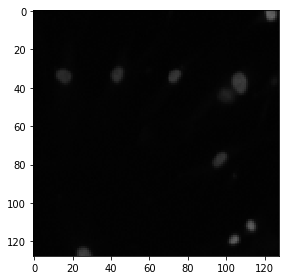

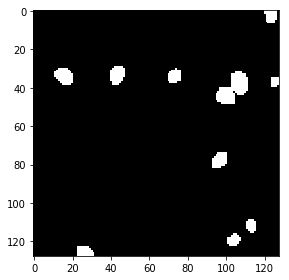

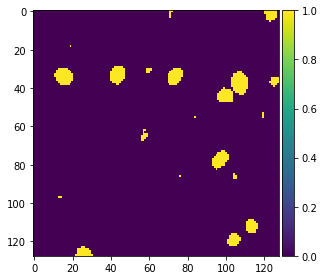

In [116]:
# Lets see some of the samples we are getting
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()

imshow(np.squeeze(Y_train[ix]))
plt.show()

imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Encoding and submitting the results
+ The results need to be in RLE format (run length encoding)
+ The RLE code is taken from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python

In [34]:
def rle(x):
    dots=np.where(x.T.flatten()==1)[0]
    run_lengths=[]
    prev=-2
    for b in dots:
        if (b>prev+1):run_lengths.extend((b+1,0))
        run_lengths[-1]+=1
        prev=b
    return run_lengths

def prob_to_rle(x, cutoff=0.5):
    lab_img=label(x>cutoff)
    for i in range(1, lab_img.max()+1):
        yield rle(lab_img==i)

In [119]:
# Iterate over the test IDs and generate RLE for each separate masks
new_test_ids=[]
rles=[]
for n, id_ in enumerate(test_ids):
    rle_=list(prob_to_rle(pred_test_unsampled[n]))
    rles.extend(rle_)
    new_test_ids.extend([id_]*len(rle_))

In [121]:
#create the submission Dataframe and excel
sub=pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels']=pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-cnn-4th.csv', index=False)

### Results and Scores on the LB
- This just scores 0.147 LB , which is pretty Low, on the LB score.
- One thing we can conclude at least is that a Simple CNN also works and is able to predict a mask which somehow resembles the actuat training images
- On the test set we did not do too good
- I will try to explore into some of the other Architectures and see how I perform with those on the LB
- I tried fiddling with Resnet50 , but I think Direct Transfer learning approach is not required here for reasons below
    + Transfer learning is based on the imagenet Dataset, which is mostly used for image recognition and not image segmentation of cells
    + Resnet50 also does not give me a output that is compatible to do IoU

## Resnet50
+ Trying to experiment with the YOLO model for Cell detection : https://github.com/experiencor/basic-yolo-keras/blob/master/examples/Blood%20Cell%20Detection.ipynb
+ The output for the model with maxpooling comes out to be of the dim [7,7,1] , so I am reducing my masks to that

In [17]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
model_resnet=ResNet50(weights='imagenet')


In [18]:
X_train_resnet = np.zeros((len(train_ids), 224, 224, IMG_CHANNELS), dtype=np.uint8)
Y_train_resnet = np.zeros((len(train_ids), 224, 224, 1), dtype=np.bool)
print('Getting and resizing train images and masks')
sys.stdout.flush()

c=0
# reshape into (224,224)
for n, id_ in tqdm(enumerate(files_train)):
    id_train = files_train[n].key.split('/')
    if 'images' in id_train:
        img = imread(files_train[n].get()['Body'])[:,:,:IMG_CHANNELS]
        img=resize(img,  (224, 224), mode='constant', preserve_range=True)
        X_train_resnet[c]=img
        c+=1
        mask=np.zeros((224,224,1), dtype=np.bool)
        #mask=np.zeros((7,7,1), dtype=np.bool)
    elif 'masks' in id_train:
        mask_=imread(files_train[n].get()['Body'])
        mask_=np.expand_dims(resize(mask_, (224, 224), mode='constant', preserve_range=True), axis=-1)
        #mask_=np.expand_dims(resize(mask_, (7, 7), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
        Y_train_resnet[c-1]=mask
print(c)        

Getting and resizing train images and masks


30131it [22:45, 22.06it/s]

670


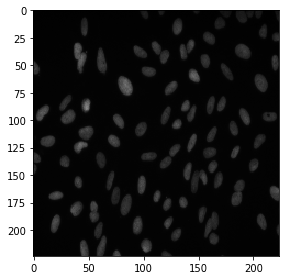

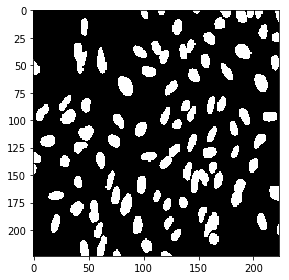

In [19]:
idx = random.randint(0, len(train_ids))
imshow(X_train_resnet[idx])
plt.show()

imshow(np.squeeze(Y_train_resnet[idx]))
plt.show()

In [20]:
#Reshape and resize the test images for resnet50 model

X_test_resnet=np.zeros((len(test_ids), 224, 224, IMG_CHANNELS), dtype=np.uint8)
sizes_test=[]
print('Getting and resizing the test  images...')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(files_test), total=len(files_test)):
    img=imread(files_test[n].get()['Body'])[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img=resize(img, (224,224), mode='constant', preserve_range=True)
    X_test_resnet[n]=img
print('Done the processing !!')

Getting and resizing the test  images...


100%|██████████| 65/65 [00:06<00:00, 10.72it/s]

Done the processing !!


65


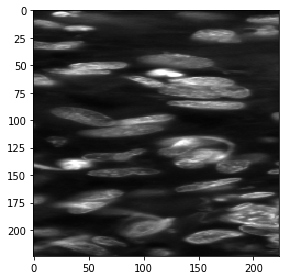

In [23]:
print(len(X_test_resnet))
idx=random.randint(0, len(test_ids))
imshow(X_test_resnet[idx])
plt.show()

In [24]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
from tqdm import tqdm_notebook
import numpy as np
import json
import pickle
import os, cv2


# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [25]:
# A new model description using YOLO

# Build U-Net model
inputs = Input((224, 224, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs) #Normalization 

# Upconversion
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

#Downconversion
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model_unet = Model(inputs=[inputs], outputs=[outputs])
model_unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model_unet.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 224, 224, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [30]:
# Do the Training using the YOLO (you only look once) cnn model

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-mode-unet-v1p0-cnn-ep-100.h5', verbose=1, save_best_only=True)
results = model_unet.fit(X_train_resnet, Y_train_resnet, validation_split=0.1, batch_size=16, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/100
603/603 [==============================] - 471s 781ms/step - loss: 0.1707 - mean_iou: 0.5864 - val_loss: 0.1396 - val_mean_iou: 0.6432
Epoch 2/100
603/603 [==============================] - 470s 779ms/step - loss: 0.1310 - mean_iou: 0.6769 - val_loss: 0.1171 - val_mean_iou: 0.7030
Epoch 3/100
603/603 [==============================] - 471s 781ms/step - loss: 0.1096 - mean_iou: 0.7223 - val_loss: 0.1008 - val_mean_iou: 0.7391
Epoch 4/100
603/603 [==============================] - 471s 781ms/step - loss: 0.0982 - mean_iou: 0.7524 - val_loss: 0.0956 - val_mean_iou: 0.7639
Epoch 5/100
603/603 [==============================] - 470s 780ms/step - loss: 0.0957 - mean_iou: 0.7728 - val_loss: 0.1004 - val_mean_iou: 0.7810
Epoch 6/100
603/603 [==============================] - 471s 781ms/step - loss: 0.0883 - mean_iou: 0.7879 - val_loss: 0.1063 - val_mean_iou: 0.7944
Epoch 7/100
603/603 [==============================] - 471s 782ms/step - 

Epoch 27/100
603/603 [==============================] - 471s 780ms/step - loss: 0.0705 - mean_iou: 0.8667 - val_loss: 0.0670 - val_mean_iou: 0.8672
Epoch 28/100
603/603 [==============================] - 470s 779ms/step - loss: 0.0686 - mean_iou: 0.8678 - val_loss: 0.0690 - val_mean_iou: 0.8684
Epoch 29/100
603/603 [==============================] - 470s 780ms/step - loss: 0.0697 - mean_iou: 0.8689 - val_loss: 0.0711 - val_mean_iou: 0.8694
Epoch 30/100
603/603 [==============================] - 470s 780ms/step - loss: 0.0694 - mean_iou: 0.8699 - val_loss: 0.0798 - val_mean_iou: 0.8703
Epoch 31/100
603/603 [==============================] - 470s 779ms/step - loss: 0.0688 - mean_iou: 0.8708 - val_loss: 0.0772 - val_mean_iou: 0.8712
Epoch 32/100
603/603 [==============================] - 470s 780ms/step - loss: 0.0694 - mean_iou: 0.8717 - val_loss: 0.0702 - val_mean_iou: 0.8721
Epoch 00032: early stopping


In [26]:
# Stopped early as the Loss does not seem to be improving any further

#load the model and predict on the train , test and the validation set
model_unet_=load_model('model-dsbowl2018-mode-unet-v1p0-cnn-ep-100.h5', custom_objects={'mean_iou':mean_iou})
pred_train_ = model_unet_.predict(X_train_resnet[:int(len(train_ids)*0.9)], verbose=1)
pred_val_ = model_unet_.predict(X_train_resnet[int(len(train_ids)*0.9):], verbose=1)
pred_test_ = model_unet_.predict(X_test_resnet, verbose=1)


#threshold to correctly predict
pred_train_th = (pred_train_>0.5).astype(np.uint8)
pred_val_th = (pred_val_>0.5).astype(np.uint8)
pred_test_th = (pred_test_>0.5).astype(np.uint8)

#create a list of unsampled test masks to compare
pred_test_unsampled=[]
for i in range(len(pred_test_)):
    pred_test_unsampled.append(resize(np.squeeze(pred_test_[i]),
                                     (sizes_test[i][0], sizes_test[i][1]),
                                     mode='constant', preserve_range=True))

65/65 [==============================] - 16s 247ms/step


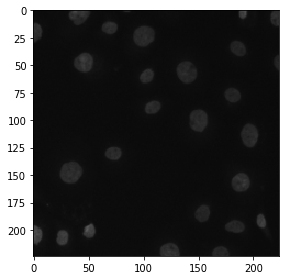

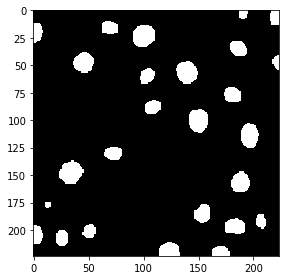

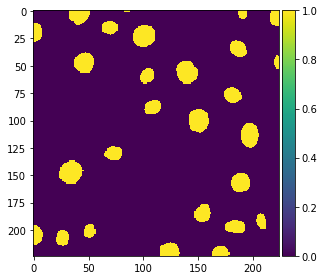

In [29]:
# Perform a sanity check 

#pick a image in the training set
ix = random.randint(0, len(pred_train_th))
imshow(X_train_resnet[ix])
plt.show()

imshow(np.squeeze(Y_train_resnet[ix]))
plt.show()

imshow(np.squeeze(pred_train_th[ix]))
plt.show()

#### This is able to predict the mask somewhat ok 

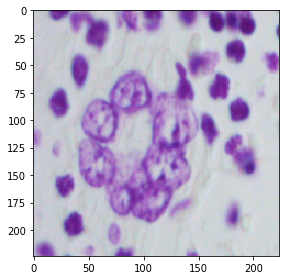

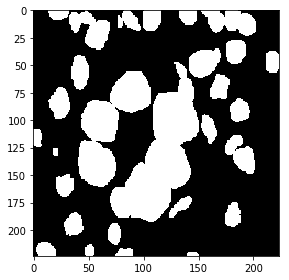

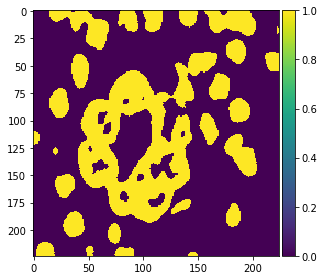

In [33]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(pred_val_th))
imshow(X_train_resnet[int(len(train_ids)*0.9):][ix])
plt.show()

imshow(np.squeeze(Y_train_resnet[int(len(train_ids)*0.9):][ix]))
plt.show()

imshow(np.squeeze(pred_val_th[ix]))
plt.show()


# Run Length Encode and submit our results

+ Need to see more improvement , Plain U-net no image augmentation yet

+ Now it's time to submit our results. I've stolen [this](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) excellent implementation of run-length encoding.

In [35]:
new_test_ids = []
rles=[]
for n, id_ in enumerate(test_ids):
    rle_=list(prob_to_rle(pred_test_unsampled[n]))
    rles.extend(rle_)
    new_test_ids.extend([id_]*len(rle_))

In [37]:
# Now put the values in the .csv format to submit , use pandas for this
sub=pd.DataFrame()
sub['ImageId']=new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x:' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-unet-ep-32-5th.csv',index=False)

## Best Submission yet , This submission reached a LB score of 0.282
+ This is my Best submission yet on 3/18 . LB score = 0.282 , ranks at top 60% 
+ This is a significant improvement from my simple CNN submission which achieves only 0.146 score
+ Further improvement could be put here by the use of data Augmentation, which will be mu next attempt
+ Looking over some of the kernels, I see that I am doing better than most of the other kernels that were in the discussion forums , so I think it will be tough to go beyond this
+ The Model is based on https://arxiv.org/abs/1505.04597 , seems the unet architecture came up in 2015 and was considered best at that time for Biomedical image segmentation
+ I will aslo see if I can improve and tweak on the current U-net model to achieve a better score without image augmentation